# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Отправка финального решения на лидерборд на Kaggle
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти


In [704]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.inspection import permutation_importance
from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from sklearn.model_selection import train_test_split, KFold
import shap
import optuna
from scipy.stats import mode
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from bs4 import BeautifulSoup
from tqdm import tqdm
import requests


# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [298]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
2273,K-1544774T,Kia Rio,economy,petrol,6.82,2014,63620,2019,32.94,break_bug
293,n20592045x,VW Polo VI,economy,petrol,3.78,2013,38272,2014,32.58,gear_stick
979,f55908334b,VW Polo,economy,petrol,2.60,2012,19697,2019,41.06,gear_stick
912,B-8479157Q,Kia Rio X-line,economy,petrol,5.78,2014,65086,2016,55.58,engine_ignition
2157,o-2139524M,VW Tiguan,economy,petrol,5.26,2017,121392,2020,30.81,electro_bug


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [299]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
248075,Z10407553e,R-5073928i,n1w,2020-03-07,6.72,16,795,40,56.323926,0,606.102630,0,9.242095,-6.907
430909,K39953526z,e12051793m,f1h,2020-02-15,2.50,30,294,52,81.000000,0,1291.234100,0,-4.873512,-0.988
299185,t18637461q,V-1552956h,f1J,2020-02-11,0.00,377,4519,46,84.361258,1,2226.278737,0,0.231362,-19.595
697147,c14218099U,x-1331305Z,T1i,2020-02-24,0.00,69,891,57,83.986735,2,3209.326479,0,-17.754319,2.217
681523,x18462490B,v92032706J,x1m,2020-03-14,2.24,77,688,50,66.000000,1,1818.897585,0,-1.741987,9.588


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [300]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
4941,44,7.7,744,12.0,o83147198N,0,2019-4-30
4862,48,8.5,1111,5.0,V43203107j,0,2019-1-25
2681,18,9.1,1438,20.0,t89824271o,1,2018-8-6
8482,21,7.4,826,4.0,E65380697E,1,2020-9-17
4553,51,8.6,917,11.0,v19960711m,0,2021-1-8


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [301]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
68873,P-7445835e,IC,2018-6-5 6:2,reparking,1.0,26
60245,t-9455268R,OB,2019-8-30 8:41,refuel_check,1.0,26
7943,z22596029p,NL,2020-2-8 18:27,repair,10.0,61
62125,G17430753s,EM,2019-6-24 22:55,reparking,1.0,24
24695,s18801959g,XH,2019-7-13 8:23,reparking,1.0,27


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.

6. **ОБЯЗАТЕЛЬНО!** Проверьте, что кол-во строк в полученном датафрейме равно изначальному кол-ву строк в исходном датасете car_train. Убедитесь, что нет дублей. (За это будут снижать баллы)


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Пример расчета признака

In [ ]:
# Пример расчета одного признака
rides_info.groupby('car_id', as_index=False).agg(
    mean_rating = ('rating', 'mean'),
    # ... еще признаки
)

df = pd.merge(...) # Соедините полученный датасет с фичами с основным датасетом

# YOUR CODE HERE

In [302]:
# Add rides_info to car_train
group_by_car = rides_info.groupby('car_id', as_index=False).agg(
    min_rating = ('rating', 'min'),
    mean_rating = ('rating', 'mean'),
    sum_distance = ('distance', 'sum'),
    speed_max = ('speed_max', 'max'),
    sum_rides = ('ride_id', 'count'),
    min_user_ride_quality = ('user_ride_quality', 'min'),
    mean_user_ride_quality = ('user_ride_quality', 'mean'),
    mean_deviation_normal = ('deviation_normal', 'mean')
)
df = pd.merge(car_train, group_by_car, how='inner', on='car_id')

# Add fix_info to car_train
group_by_car2 = fix_info.groupby('car_id', as_index=False).agg(
    max_destroy_degree = ('destroy_degree', 'max'),
    mean_destroy_degree = ('destroy_degree', 'mean'),
    sum_repair = ('work_type', lambda x: (x == 'repair').sum())
)
df = pd.merge(df, group_by_car2, how='inner', on='car_id')

# Add driver_info to car_train
df2 = pd.merge(rides_info, driver_info, how='inner', on='user_id')
group_by_car3 = df2.groupby('car_id', as_index=False).agg(
    mean_user_time_accident = ('user_time_accident', 'mean'),
    mean_user_rides = ('user_rides', 'mean'),
    sum_young_age_riders = ('age', lambda x: (x <= 25).sum())
)
df = pd.merge(df, group_by_car3, how='inner', on='car_id')
df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,sum_rides,min_user_ride_quality,mean_user_ride_quality,mean_deviation_normal,max_destroy_degree,mean_destroy_degree,sum_repair,mean_user_time_accident,mean_user_rides,sum_young_age_riders
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,108.53,another_bug,...,174,-10.501738,-0.901190,-0.120391,9.0,3.048571,12,17.724138,828.034483,44
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,35.20,electro_bug,...,174,0.437053,14.018105,6.050011,10.0,2.917143,13,6.965517,924.804598,30
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,38.62,gear_stick,...,174,-12.535368,0.722771,-2.223954,10.0,3.740000,14,9.775862,940.040230,39
3,u29695600e,Mercedes-Benz GLC,business,petrol,4.04,2011,1263,2020,30.34,engine_fuel,...,174,-10.723544,-4.290370,14.771948,10.0,4.085714,17,19.991304,951.126437,27
4,N-8915870N,Renault Sandero,standart,petrol,4.70,2012,26428,2017,30.45,engine_fuel,...,174,-25.742137,-13.465342,12.455678,10.0,3.880000,15,15.758333,896.229885,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,Smart ForFour,economy,petrol,4.38,2017,121239,2018,25.48,wheel_shake,...,174,-21.867121,-5.722741,2.914989,10.0,3.900000,19,20.203390,885.149425,54
2333,h-1554287F,Audi A4,premium,petrol,4.30,2016,107793,2020,69.26,engine_check,...,174,-17.949058,-8.048019,-18.805856,5.0,1.935294,9,18.041322,1044.402299,34
2334,A15262612g,Kia Rio,economy,petrol,3.88,2015,80234,2019,46.03,gear_stick,...,174,-12.441852,-0.251597,-7.651776,7.4,2.782353,14,8.804598,850.086207,55
2335,W-2514493U,Renault Sandero,standart,petrol,4.50,2014,60048,2020,77.19,another_bug,...,174,-12.514535,0.424606,0.468718,10.0,3.441176,14,17.008547,858.586207,63


In [303]:
df.duplicated().sum()

0

### Идеи для новых признаков


* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

In [ ]:
# YOUR CODE HERE

## 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [304]:
# YOUR CODE HERE
# drop const and ids
df.drop(['car_id', 'sum_rides'], axis=1, inplace=True)

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'sum_distance', 'speed_max', 'min_user_ride_quality', 'mean_user_ride_quality', 'mean_deviation_normal', 'max_destroy_degree', 'mean_destroy_degree', 'sum_repair', 'mean_user_time_accident', 'mean_user_rides', 'sum_young_age_riders']


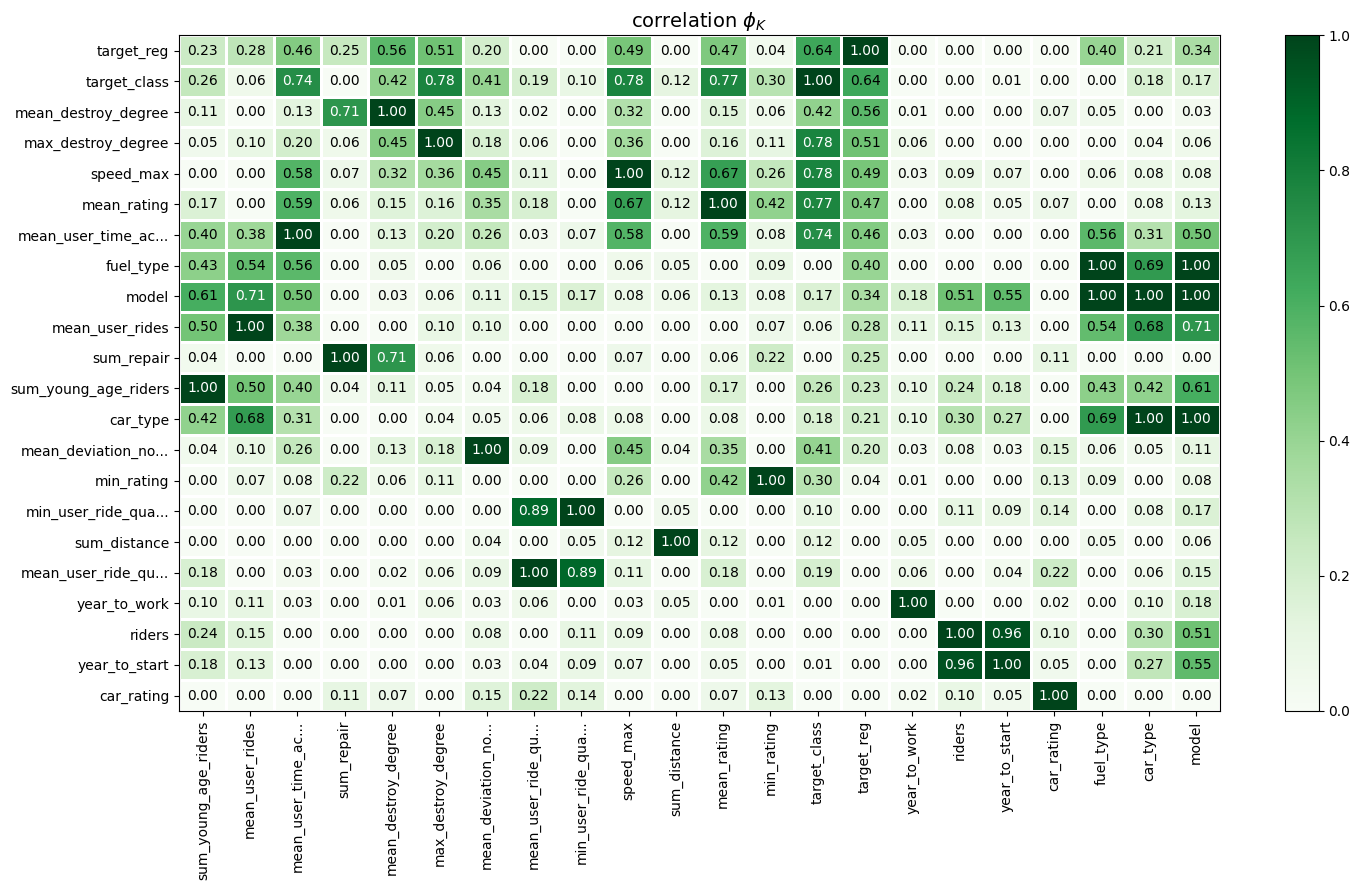

In [236]:
# Phik method
phik_overview = df.phik_matrix().round(2).sort_values('target_reg')

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, figsize=(15, 9))
plt.tight_layout()

interval columns not set, guessing: ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'target_reg', 'min_rating', 'mean_rating', 'sum_distance', 'speed_max', 'min_user_ride_quality', 'mean_user_ride_quality', 'mean_deviation_normal', 'max_destroy_degree', 'mean_destroy_degree', 'sum_repair', 'mean_user_time_accident', 'mean_user_rides', 'sum_young_age_riders']


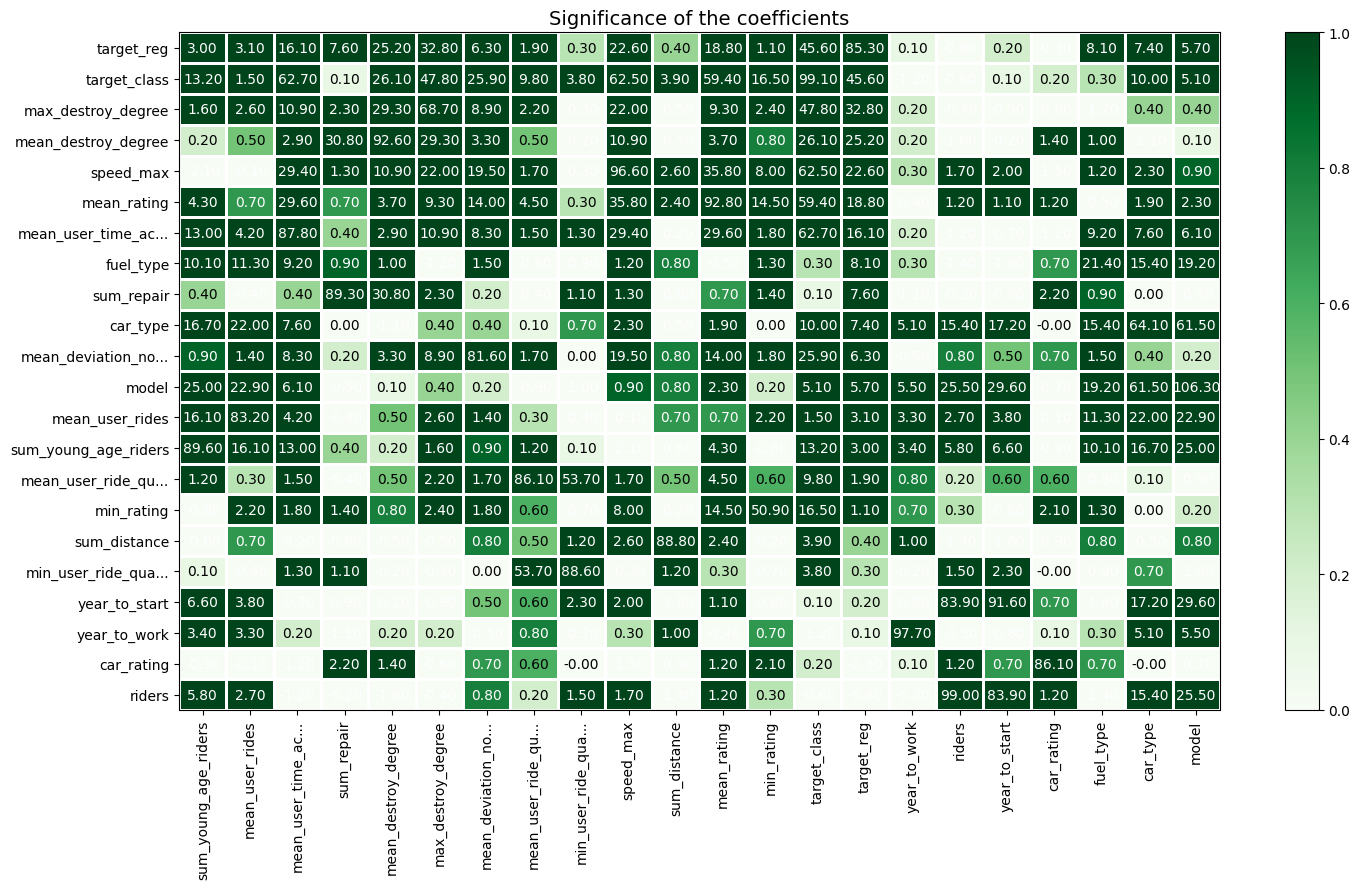

In [237]:
significance_overview = df.significance_matrix().fillna(0).round(1).sort_values('target_reg')

plot_correlation_matrix(significance_overview.values, 
                        x_labels=significance_overview.columns, 
                        y_labels=significance_overview.index, 
                        vmin=0, vmax=1, color_map="Greens",
                        title="Significance of the coefficients", 
                        usetex=False, fontsize_factor=1, figsize=(15, 9))
plt.tight_layout()

In [305]:
# Permutation Importance method
X = df.drop(['target_class', 'target_reg'], axis=1, errors = 'ignore')
y = df['target_class'].fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = CatBoostClassifier(random_state=42, cat_features=['car_type', 
                                                          'fuel_type', 'model'])
model.fit(X_train, y_train, 
          eval_set=(X_test, y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.6335806	test: 1.6403140	best: 1.6403140 (0)	total: 44.9ms	remaining: 44.8s
100:	learn: 0.0505470	test: 0.0854992	best: 0.0854817 (99)	total: 4.93s	remaining: 43.9s
200:	learn: 0.0282925	test: 0.0718318	best: 0.0718318 (200)	total: 9.78s	remaining: 38.9s
300:	learn: 0.0185739	test: 0.0678888	best: 0.0677340 (297)	total: 14.6s	remaining: 34s
400:	learn: 0.0139027	test: 0.0658556	best: 0.0657304 (395)	total: 19.6s	remaining: 29.3s
500:	learn: 0.0104590	test: 0.0639627	best: 0.0639627 (500)	total: 24.6s	remaining: 24.5s
600:	learn: 0.0083066	test: 0.0627861	best: 0.0626745 (579)	total: 29.7s	remaining: 19.7s
700:	learn: 0.0066873	test: 0.0623758	best: 0.0622376 (646)	total: 34.8s	remaining: 14.8s
800:	learn: 0.0056535	test: 0.0619737	best: 0.0618717 (798)	total: 39.9s	remaining: 9.91s
900:	learn: 0.0047996	test: 0.0619379	best: 0.0617553 (863)	total: 44.7s	remaining: 4.92s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0617553

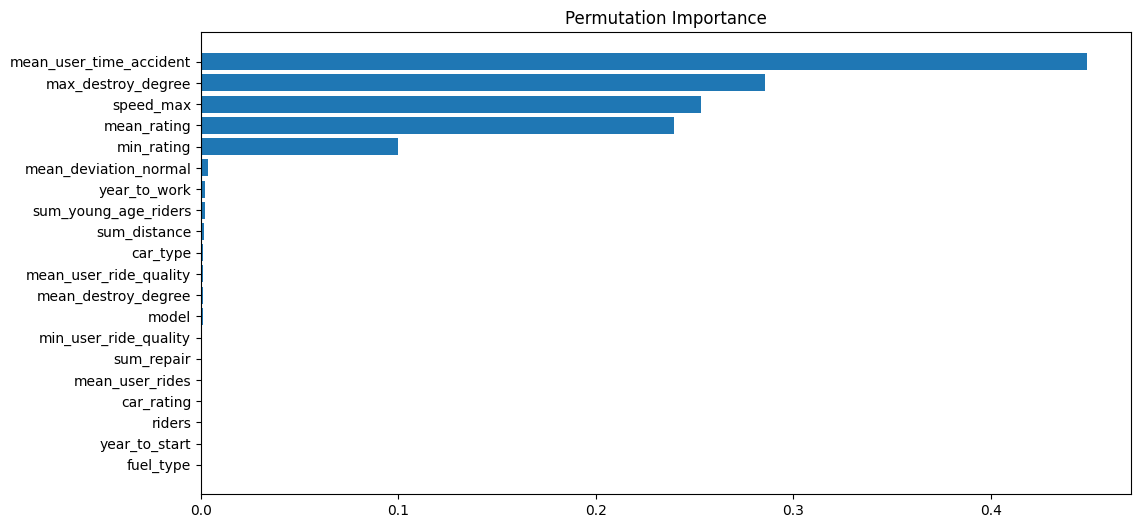

In [306]:
perm_importance = permutation_importance(model, X_test, y_test, 
                                         n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Permutation Importance');

In [307]:
# CatBoost Feature Selection
summary = model.select_features(X_train, y_train, 
                      eval_set=(X_test, y_test),
                      features_for_select='0-19',
                      num_features_to_select=14,
                      steps=1,
                      train_final_model=False,
                      logging_level='Silent',
                      algorithm='RecursiveByShapValues')

In [308]:
print(summary['selected_features_names'])
print(f"Best loss: {summary['loss_graph']['loss_values'][-1]}")

['model', 'car_type', 'fuel_type', 'min_rating', 'mean_rating', 'speed_max', 'min_user_ride_quality', 'mean_user_ride_quality', 'mean_deviation_normal', 'max_destroy_degree', 'mean_destroy_degree', 'sum_repair', 'mean_user_time_accident', 'mean_user_rides']
Best loss: 0.05947194278689403


In [309]:
# ТОП-10 признаков для проверки изменения точности модели
important_features = ['mean_user_time_accident', 'max_destroy_degree', 
                      'speed_max', 'mean_rating', 
                      'min_rating', 'mean_deviation_normal',
                      'mean_user_ride_quality', 
                      'car_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

model = CatBoostClassifier(random_state=42, cat_features=['car_type'])


model.fit(X_train[important_features], y_train, 
          eval_set=(X_test[important_features], y_test),
          verbose=100, plot=False, 
          early_stopping_rounds=100)

Learning rate set to 0.109335
0:	learn: 1.5794871	test: 1.5793489	best: 1.5793489 (0)	total: 42.9ms	remaining: 42.9s
100:	learn: 0.0408928	test: 0.0751702	best: 0.0751702 (100)	total: 3.75s	remaining: 33.4s
200:	learn: 0.0212950	test: 0.0611229	best: 0.0611229 (200)	total: 7.48s	remaining: 29.7s
300:	learn: 0.0137150	test: 0.0576203	best: 0.0576203 (300)	total: 11.2s	remaining: 26s
400:	learn: 0.0097603	test: 0.0569528	best: 0.0567472 (364)	total: 14.9s	remaining: 22.3s
500:	learn: 0.0075560	test: 0.0562368	best: 0.0560753 (482)	total: 18.5s	remaining: 18.5s
600:	learn: 0.0061591	test: 0.0558232	best: 0.0558232 (600)	total: 22.1s	remaining: 14.7s
700:	learn: 0.0049881	test: 0.0563153	best: 0.0556855 (614)	total: 25.8s	remaining: 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.0556855326
bestIteration = 614

Shrink model to first 615 iterations.


Выводы:
* Выбор признаков на основе анализа позволил сократить ошибку с 0.061 до 0.055.
* Были выбраны общие признаки, которые находятся в топ показателях среди 3-х методов отбора.
* Наиболее информативным представляется метод permutation_importance, поскольку он дает процентную характеристику и по результатам был подтвержден CatBoost Feature Selection.


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

## 1. Обучение первой модели (5 баллов)

1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки (убрать оба таргета), а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно). Отключите или минимизируйте логирование при обучении.

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [310]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [311]:
# YOUR CODE HERE
# Классификация признаков с учетом задания 1
targets = ['target_class', 'target_reg']
cat_features = ['car_type']
num_features =['mean_user_time_accident', 'max_destroy_degree', 
                'speed_max', 'mean_rating', 
                'min_rating', 'mean_deviation_normal',
                'mean_user_ride_quality']

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

# Выделим X и Y и разобъем на train/test
X = df[num_features+cat_features]
Y = df[targets[0]]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, 
                                                    random_state=42)

model = CatBoostClassifier(random_state=42, cat_features=cat_features)

# Обучение модели
model.fit(X_train, y_train, 
          verbose=False, plot=False, 
          early_stopping_rounds=100
          )

# Оценка модели accuracy
y_pred = model.predict(X_test)
acc_score = accuracy_score(y_test, y_pred)
print('Оценка модели accuracy:',acc_score)

Категориальные признаки: 1 ['car_type']
Числовые признаки: 7 ['mean_user_time_accident', 'max_destroy_degree', 'speed_max', 'mean_rating', 'min_rating', 'mean_deviation_normal', 'mean_user_ride_quality']
Целевые переменные ['target_class', 'target_reg']
Оценка модели accuracy: 0.9871794871794872


## 2. Визуализация прогнозов, ошибок модели и важности признаков (5 баллов)

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

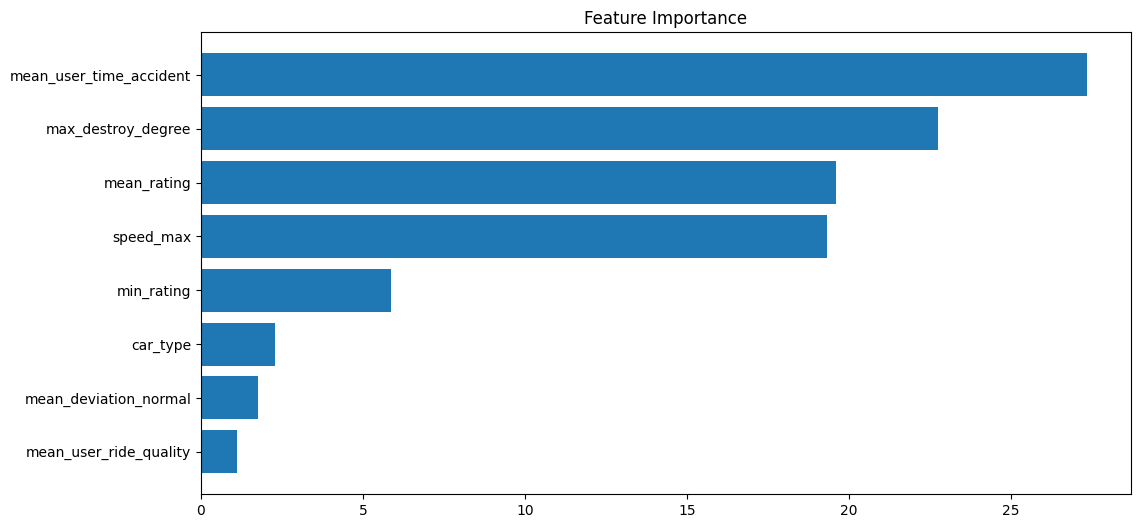

In [245]:
# YOUR CODE HERE
# Feature importance CatBoost
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance');

Вывод: встроенный метод определил, что наиболее важные признаки - среднее количество аварий пользователя, максимальная степень повреждения, средний рейтинг и максимальная скорость езды. Однако мы не можем доверять этому рейтингу на 100%, тк он делит сильно скоррелированные признаки попопам.

In [19]:
# waterfall vizualization
shap.initjs()

explainer = shap.TreeExplainer(model, feature_perturbation="tree_path_dependent")
shap_values = explainer(X_train)


shap.plots.waterfall(shap_values[0][0])

TypeError: only length-1 arrays can be converted to Python scalars

In [246]:
# Classification Report
report = pd.DataFrame(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=model.classes_,
                            output_dict=True)).T

report.style.background_gradient(cmap='Blues', 
                                 subset=pd.IndexSlice['another_bug':'wheel_shake',
                                                      :'f1-score'])

,precision,recall,f1-score,support
another_bug,0.965517,0.965517,0.965517,58.000000
break_bug,1.000000,1.000000,1.000000,56.000000
electro_bug,1.000000,1.000000,1.000000,51.000000
engine_check,1.000000,1.000000,1.000000,49.000000
engine_fuel,0.966667,1.000000,0.983051,58.000000
engine_ignition,0.983051,1.000000,0.991453,58.000000
engine_overheat,1.000000,0.958333,0.978723,48.000000
gear_stick,1.000000,1.000000,1.000000,51.000000
wheel_shake,0.973684,0.948718,0.961039,39.000000
accuracy,0.987179,0.987179,0.987179,0.987179


Вывод: Модель в целом работает хорошо, однако можно заметить, что оценки для классов wheel_shake и another_bug хуже. Возможно, мы не учли при отборе признаки, которые могли бы хорошо определять эти классы. support показывает какое количество объектов было отнесено к классу, присутствует некий дисбаланс класса wheel_shake в предсказании. 

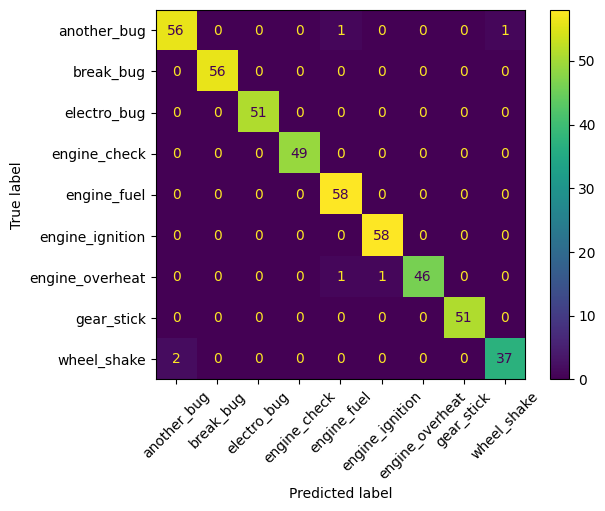

In [247]:
# Матрица смежности
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, 
                                      xticks_rotation = 45)
plt.show()

Вывод: В данном случае видим ошибки в определении классов. К примеру, хотя количество объектов, отнесенных к another_bug было 58 при оценке 0,96, confusion_matrix показывает, что в двух случаях wheel_shake было отнесено к another_bug (что показал Precisiom), а также в отном случае another_bug был отнесен к wheel_shake(что показал Recall). Так, если объекты ложно классифицируются между двумя классами, то у них схожие показатели признаков, и нужно найти те признаки, которые бы их разделили более четко.

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna` (10 баллов)

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

1. Напишите `objective` функцию и запустите `Optuna` (минимум 50 итераций).
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.
4. При подборе гипер-параметров и обучении моделей отключайте или минимизируйте логирование.

<h4> Критерии оценивания </h4>
    
* За корректный `objective` и запуск подбора - 3 балла
* За корректный выбор гиперпараметров для оптимизации - 3 балла
* Обучение модели с подобранными гиперпараметрами - 3 балла
* За корректную работу с логами - 1 балл
    
</div>

In [248]:
# YOUR CODE HERE
# Функция обучения с гиперпараметрами для подбора
def fit_catboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'depth': trial.suggest_int('depth', 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 50),
        "auto_class_weights": trial.suggest_categorical("auto_class_weights", ["SqrtBalanced", "Balanced", None]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"])
    }

    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.4, 1)
        

    clf = CatBoostClassifier(
        **param,
        iterations=200,
        thread_count=-1,
        random_seed=42,
        cat_features=cat_features, 
        eval_metric='Accuracy'
    )

    clf.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        verbose=0,
        plot=False,
        early_stopping_rounds=5,
    )

    y_pred = clf.predict(X_val)
    return clf, y_pred

In [249]:
# `objective` функция
def objective(trial, return_models=False):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        model, y_pred = fit_catboost(trial, train_data, valid_data)
        
        scores.append(accuracy_score(valid_data[1], y_pred))
        models.append(model)
         
    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result

In [23]:
# Запуск `Optuna` (минимум 50 итераций)
study = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study.optimize(objective,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)

[I 2025-04-15 19:33:35,494] A new study created in memory with name: no-name-1613b0aa-b159-47a8-83ac-17142614c567


  0%|          | 0/100 [00:00<?, ?it/s]

In [24]:
print("Best trial: score {}, params {}".format(study.best_trial.value, study.best_trial.params))

Best trial: score 0.986620980344368, params {'depth': 10, 'learning_rate': 0.041262477084419436, 'l2_leaf_reg': 12.282477870341406, 'auto_class_weights': 'Balanced', 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [25]:
1-0.98717/0.98768

0.0005163615745991113

Оценка старой модели без подбора гиперпараметров - модели accuracy: 0.98717, а новая - 0.98768. Мы видим, что оптимизация гиперпараметров работает, и дает хоть и несущественный результат, но повышение метрики на 0.05%. Низкий результат связан с тем, что это максимальная точность модели при выбранных признаках и исходных данных.

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

1. Построить и обучить модели:


    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.

    Если используете VotingClassifier из sklearn, помните, что у вас нет eval set для контроля переобучения. Поэтому стоит предварительно провести подбор гипер-параметров.
4. Отключайте или минимизируйте логирование (Будут снижаться баллы).
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [312]:
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [27]:
# CatBoostClassifier построен выше
# LightGBMClassifier (goss)
def fit_lightgbm(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'num_leaves': trial.suggest_int('num_leaves', 15, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0)
    }      

    clf_lightgbm = LGBMClassifier(
        **param,
        boosting_type='goss',
        random_state=42,
        verbosity= -1,
        early_stopping_rounds = 5,
        force_col_wise=True
    )

    clf_lightgbm.fit(
        X_train,
        y_train,
        eval_set=(X_val, y_val),
        categorical_feature=cat_features,
    )

    y_pred = clf_lightgbm.predict(X_val)
    return clf_lightgbm, y_pred


def objective_lightgbm(trial, return_models=False):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train.iloc[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train.iloc[valid_idx]

        model, y_pred = fit_lightgbm(trial, train_data, valid_data)
        
        scores.append(accuracy_score(valid_data[1], y_pred))
        models.append(model)
         
    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
    
study_lightgbm = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study_lightgbm.optimize(objective_lightgbm,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)    



  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
print("Best trial: score {}, params {}".format(study_lightgbm.best_trial.value, study_lightgbm.best_trial.params))

Best trial: score 0.9876919327321471, params {'num_leaves': 165, 'learning_rate': 0.09821349352021864, 'n_estimators': 153, 'reg_alpha': 8.945558441062879, 'reg_lambda': 6.630451210488165}


In [313]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [30]:
# XGBoostClassifier (dart)
def fit_xgboost(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'eta': trial.suggest_float('eta', 0.001, 0.1),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'rate_drop': trial.suggest_float('rate_drop', 0.0, 0.3),
        'lambda': trial.suggest_float('lambda', 1e-5, 1.0),
        'alpha': trial.suggest_float('alpha', 1e-5, 1.0),
    }      

    clf_xgboost = XGBClassifier(
        **param,
        booster='dart',
        random_state=42,
        early_stopping_rounds = 5,
        enable_categorical=True
    )

    clf_xgboost.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=0
    )

    y_pred = clf_xgboost.predict(X_val)
    return clf_xgboost, y_pred


def objective_xgboost(trial, return_models=False):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train):
        train_data = X_train.iloc[train_idx, :], y_train_encoded[train_idx]
        valid_data = X_train.iloc[valid_idx, :], y_train_encoded[valid_idx]

        model, y_pred = fit_xgboost(trial, train_data, valid_data)
        
        scores.append(accuracy_score(valid_data[1], y_pred))
        models.append(model)
         
    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
    
study_xgboost = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study_xgboost.optimize(objective_xgboost,
               n_trials=100,
               n_jobs = -1,
               show_progress_bar=True,)    


  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
print("Best trial: score {}, params {}".format(study_xgboost.best_trial.value, study_xgboost.best_trial.params))

Best trial: score 0.9850210032831072, params {'eta': 0.06763205866629693, 'max_depth': 5, 'rate_drop': 0.0058484019644032045, 'lambda': 0.8113082159235603, 'alpha': 0.3668009734713085}


In [314]:
# Кодируем категориальные признаки перед обучением
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', StandardScaler(), num_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [254]:
# RandomForestClassifier
def fit_rf(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val

    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 4, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
    }      

    clf_rf = RandomForestClassifier(
        **param,
        random_state=42,
        verbose=0
    )

    clf_rf.fit(
        X_train,
        y_train
    )

    y_pred = clf_rf.predict(X_val)
    return clf_rf, y_pred


def objective_rf(trial, return_models=False):
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    scores, models = [], []
    
    for train_idx, valid_idx in kf.split(X_train_processed):
        train_data = X_train_processed[train_idx], y_train_encoded[train_idx]
        valid_data = X_train_processed[valid_idx], y_train_encoded[valid_idx]

        model, y_pred = fit_rf(trial, train_data, valid_data)
        
        scores.append(accuracy_score(valid_data[1], y_pred))
        models.append(model)
         
    result = np.mean(scores)
    
    if return_models:
        return result, models
    else:
        return result
    
study_rf = optuna.create_study(direction="maximize")
optuna.logging.set_verbosity(optuna.logging.CRITICAL)
study_rf.optimize(objective_rf,
               n_trials=500,
               n_jobs = -1,
               show_progress_bar=True,)    


  0%|          | 0/500 [00:00<?, ?it/s]

In [255]:
print("Best trial: score {}, params {}".format(study_rf.best_trial.value, study_rf.best_trial.params))

Best trial: score 0.9914366819113705, params {'n_estimators': 93, 'max_depth': 19, 'min_samples_split': 18, 'min_samples_leaf': 8}


In [259]:
# Оценим качество моделей на X_test, y_test
# CatBoostClassifier
best_params = study.best_params
model = CatBoostClassifier(
    **best_params,
    iterations=200,
    thread_count=-1,
    random_seed=42,
    cat_features=cat_features,
    eval_metric='Accuracy'
)
model.fit(X_train, y_train, verbose=0, plot=False, early_stopping_rounds=5)

catboost_pred = model.predict(X_test)
accuracy_catb = accuracy_score(y_test, catboost_pred)
print(f'Test Accuracy: {accuracy_catb:.5f}')

Test Accuracy: 0.98077


In [260]:
catboost_pred = catboost_pred.flatten()
catboost_pred = le.transform(catboost_pred)

In [261]:
# Оценим качество моделей на X_test, y_test
# LightGBMClassifier (goss)
best_params = study_lightgbm.best_params
model2 = LGBMClassifier(
    **best_params,
    boosting_type='goss',
    random_state=42,
    verbosity= -1,
    force_col_wise=True
)
model2.fit(X_train, y_train, categorical_feature=cat_features)

lightgbm_pred = model2.predict(X_test)
accuracy_lightgbm = accuracy_score(y_test, lightgbm_pred)
print(f'Test Accuracy: {accuracy_lightgbm:.5f}')

Test Accuracy: 0.97863


In [262]:
lightgbm_pred = le.transform(lightgbm_pred)

In [263]:
# Оценим качество моделей на X_test, y_test
# XGBoostClassifier (dart)
best_params = study_xgboost.best_params
model3 = XGBClassifier(
    **best_params,
    booster='dart',
    random_state=42,
    enable_categorical=True
)
model3.fit(X_train, y_train_encoded, verbose=0)

xgboost_pred = model3.predict(X_test)
accuracy_xgboost = accuracy_score(y_test_encoded, xgboost_pred)
print(f'Test Accuracy: {accuracy_xgboost:.5f}')

Test Accuracy: 0.98077


In [256]:
# Оценим качество моделей на X_test, y_test
# RandomForestClassifier
best_params = study_rf.best_params
model4 = RandomForestClassifier(
    **best_params,
    random_state=42,
    verbose=0
)
model4.fit(X_train_processed, y_train_encoded)

rf_pred = model4.predict(X_test_processed)
accuracy_rf = accuracy_score(y_test_encoded, rf_pred)
print(f'Test Accuracy: {accuracy_rf:.5f}')

Test Accuracy: 0.98291


In [278]:
# Hard Voting
stacked = np.column_stack([catboost_pred, lightgbm_pred, xgboost_pred, rf_pred])
hard_vot = mode(stacked, axis=1).mode
hard_acc = accuracy_score(y_test_encoded, hard_vot)
print(f'Hard Voting Accuracy: {hard_acc:.5f}')

Hard Voting Accuracy: 0.98291


In [286]:
# Soft Voting
# сделаем предсказания с вероятностями
proba_catboost = model.predict_proba(X_test)
proba_lightgbm = model2.predict_proba(X_test)
proba_xgboost = model3.predict_proba(X_test)
proba_rf = model4.predict_proba(X_test_processed)

soft_vot = np.argmax((proba_catboost + proba_lightgbm + proba_xgboost + proba_rf) / 4, axis=1)
soft_acc = accuracy_score(y_test_encoded, soft_vot)
print(f'Soft Voting Accuracy: {soft_acc:.5f}')

Soft Voting Accuracy: 0.98291


Мы получили метрику на Soft Voting и Hard Voting 0.98291, резултат не превзошел RandomForestClassifier

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/t/bab924c25da94dcdb161fd1cef92fd97).

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.

</div>

In [315]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017


In [316]:
# сделаем предобработку и добавим признаки
df = pd.merge(car_test, group_by_car, how='inner', on='car_id')
df = pd.merge(df, group_by_car2, how='inner', on='car_id')
df = pd.merge(df, group_by_car3, how='inner', on='car_id')
df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,min_rating,mean_rating,...,sum_rides,min_user_ride_quality,mean_user_ride_quality,mean_deviation_normal,max_destroy_degree,mean_destroy_degree,sum_repair,mean_user_time_accident,mean_user_rides,sum_young_age_riders
0,P17494612l,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,0.10,3.746207,...,174,-10.297021,9.229144,16.664374,8.0,2.765714,12,9.568966,849.212644,47
1,N-1530212S,Renault Sandero,standart,petrol,4.32,2015,90014,2016,0.00,4.318966,...,174,-1.288132,12.871315,-0.082115,10.0,3.657143,16,6.896552,857.528736,42
2,B-1154399t,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,0.10,5.134655,...,174,-2.728841,17.404267,-3.915529,10.0,3.462857,15,7.557471,937.206897,40
3,F12725233R,Smart ForFour,economy,petrol,2.80,2014,68833,2021,0.83,4.617356,...,174,0.396298,18.699584,-2.228115,10.0,2.945714,11,9.064327,877.091954,36
4,l-1139189J,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,0.00,4.287471,...,174,-4.636368,6.732205,-22.839540,8.0,3.697143,18,7.068966,853.689655,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,x13640960Q,Nissan Qashqai,standart,petrol,2.44,2015,81070,2016,0.10,4.641379,...,174,-8.316690,4.270838,-2.110374,5.0,2.579412,13,17.722689,822.160920,43
1909,Z-2276652N,Renault Kaptur,standart,petrol,4.44,2014,70067,2019,0.10,3.956954,...,174,-18.148787,-4.443610,-8.613908,7.9,3.167647,15,8.821839,933.408046,47
1910,F-2165841B,Hyundai Solaris,economy,petrol,5.16,2011,6574,2022,0.22,4.607816,...,174,-44.262121,-8.275778,-1.792914,10.0,3.673529,14,9.264368,927.017241,44
1911,x-1331529J,Hyundai Solaris,economy,petrol,5.76,2015,85648,2018,0.10,4.462644,...,174,-14.216621,-4.226126,10.985103,5.0,3.032353,16,16.867188,978.873563,36


In [317]:
df.duplicated().sum()

0

In [318]:
df_result = df[['car_id']]

In [319]:
df.drop(['car_id', 'sum_rides'], axis=1, inplace=True)

In [320]:
df

,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,min_rating,mean_rating,sum_distance,speed_max,min_user_ride_quality,mean_user_ride_quality,mean_deviation_normal,max_destroy_degree,mean_destroy_degree,sum_repair,mean_user_time_accident,mean_user_rides,sum_young_age_riders
0,Skoda Rapid,economy,petrol,4.80,2013,42269,2019,0.10,3.746207,1.407539e+07,195.454152,-10.297021,9.229144,16.664374,8.0,2.765714,12,9.568966,849.212644,47
1,Renault Sandero,standart,petrol,4.32,2015,90014,2016,0.00,4.318966,1.970390e+07,181.538685,-1.288132,12.871315,-0.082115,10.0,3.657143,16,6.896552,857.528736,42
2,Smart ForTwo,economy,petrol,4.46,2015,82684,2017,0.10,5.134655,9.314946e+06,118.440645,-2.728841,17.404267,-3.915529,10.0,3.462857,15,7.557471,937.206897,40
3,Smart ForFour,economy,petrol,2.80,2014,68833,2021,0.83,4.617356,9.336838e+06,112.829785,0.396298,18.699584,-2.228115,10.0,2.945714,11,9.064327,877.091954,36
4,Skoda Rapid,economy,petrol,6.56,2013,42442,2021,0.00,4.287471,1.196250e+07,187.846088,-4.636368,6.732205,-22.839540,8.0,3.697143,18,7.068966,853.689655,33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,Nissan Qashqai,standart,petrol,2.44,2015,81070,2016,0.10,4.641379,8.035217e+06,161.000000,-8.316690,4.270838,-2.110374,5.0,2.579412,13,17.722689,822.160920,43
1909,Renault Kaptur,standart,petrol,4.44,2014,70067,2019,0.10,3.956954,1.792881e+07,195.394955,-18.148787,-4.443610,-8.613908,7.9,3.167647,15,8.821839,933.408046,47
1910,Hyundai Solaris,economy,petrol,5.16,2011,6574,2022,0.22,4.607816,1.401163e+07,113.091551,-44.262121,-8.275778,-1.792914,10.0,3.673529,14,9.264368,927.017241,44
1911,Hyundai Solaris,economy,petrol,5.76,2015,85648,2018,0.10,4.462644,1.375324e+07,154.105593,-14.216621,-4.226126,10.985103,5.0,3.032353,16,16.867188,978.873563,36


In [321]:
X_test = df[num_features+cat_features]

In [322]:
for col in cat_features:
    X_test[col] = X_test[col].astype('category')

C:\Users\Lilu\AppData\Local\Temp\ipykernel_16180\1487779751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[col] = X_test[col].astype('category')


In [323]:
# Кодируем категориальные признаки перед обучением
X_test_processed = preprocessor.transform(X_test)

In [324]:
# сделаем предсказания моделями для Soft Voting
proba_catboost = model.predict_proba(X_test)
proba_lightgbm = model2.predict_proba(X_test)
proba_xgboost = model3.predict_proba(X_test)
proba_rf = model4.predict_proba(X_test_processed)

In [325]:
# Soft Voting
soft_vot = np.argmax((proba_catboost + proba_lightgbm + proba_xgboost + proba_rf) / 4, axis=1)
soft_vot = le.inverse_transform(soft_vot)

In [326]:
df_result['target_class'] = soft_vot

C:\Users\Lilu\AppData\Local\Temp\ipykernel_16180\3193302111.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_result['target_class'] = soft_vot


In [327]:
# сохраняем результаты
df_result.to_csv("soft_vot2.csv", index=False)

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.

# Домашнее задание 5. Парсинг данных

**Цель задания**
Собрать новый датасет с помощью парсинга данных.

**Формат сдачи**

Пришлите ссылку на репозиторий, в котором находятся:
* Jupiter Notebook с кодом.
* Итоговый датасет — файл в формате .csv.

**Критерии оценки**:

* Датасет содержит все необходимые поля; размер датасета соответствует эталонному на 90% и более, обучена модель, отправлен сабмишн и выводы — 10 баллов.
* Датасет содержит все необходимые поля; размер датасета соответствует эталонному менее чем на 90%, правильная логика на этапах матчинга, парсинга доп. характеристик авто и мерджа с исходным датасетом — 8 баллов.
* Датасет содержит все или почти все необходимые поля; размер датасета соответствует эталонному менее чем на 90% допущена серьезная ошибка на одном из этапов: матчинг, парсинг доп. характеристик авто и мердж с исходным датасетом — 6 баллов.
* Получилось спарсить ссылки на модели автомобилей — 4 балла.
* Код не исполняется; нет датасета — 1 балл.

## <center> Разминаемся
В качестве первого задания вам предстоит достать значения средних зарплат по городам России. Сайт, на котором они хранятся: https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html

Ответ - датафрейм, котором города идут в алфавитном порядке.

Пример ответа:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image1.png?raw=true' width="550" >

In [406]:
r = requests.get('https://stepik.org/media/attachments/lesson/866758/mean_salary_by_city.html')
content = r.content.decode('utf-8', errors='replace') 
soup = BeautifulSoup(content, 'html.parser')

In [471]:
allcities = []
allsalaries = []

In [472]:
# ищем города
all_cities = soup.findAll('div', class_='reg_name')

for data in all_cities:
    if data.find('a', target="_blank") is not None:
        allcities.append(data.text)
        
allcities[:5]

['Анадырь', 'Москва', 'Салехард', 'Южно-Сахалинск', 'Магадан']

In [473]:
# ищем зарплаты
all_salaries = soup.findAll('span', class_='reg_salary')

for data in all_salaries:
    cleaned = data.text.replace('\xa0', '').replace('₽', '').strip()
    allsalaries.append(cleaned)
    
allsalaries[:5]

['129200', '113600', '106400', '99000', '95200']

In [479]:
# создаем dataframe
data = list(zip(allcities, allsalaries))
df = pd.DataFrame(data, columns=['city', 'mean_salary'])
df.head()

,city,mean_salary
0,Анадырь,129200
1,Москва,113600
2,Салехард,106400
3,Южно-Сахалинск,99000
4,Магадан,95200


In [481]:
# сортировка
df.sort_values(by='city', ascending=True, inplace=True)
df.head()

,city,mean_salary
41,Абакан,45300
0,Анадырь,129200
39,Ангарск,45600
20,Архангельск,53100
72,Астрахань,38000


## <center> Парсим [automobili.ru](https://automobili.ru/cars/catalog/)

В этой задаче вам предстоит спарсить дополнительные данные по моделям машин с сайта: https://automobili.ru/cars/catalog/ и добавить их в существующий датасет. Для того чтобы было проще понимать, в каком месте вы ошибаетесь (если такое происходит), мы разбили эту задачу на несколько степов, где постепенно будем парсить данный сайт.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image2.png?raw=true' width="750" >

## <center> Собираем ссылки

Для того чтобы начать доставать информацию о моделях, нужно вначале получить ссылки на эти модели. На первой странице сайта находится список всех марок. Вам нужно:

1) Собрать все ссылки на автомобильные бренды (средствами автоматического парсинга).

2) Пройтись по каждой из полученных ссылок и спарсить названия конкретных моделей автомобилей.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image3.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image4.png?raw=true' width="750" >

В итоге у вас должно найтись 325 ссылок, которые выглядят примерно так:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image5.png?raw=true' width="750" >

Ответ - датафрейм с ссылками и названием модели. Датафрейм должен быть отсортирован по названию модели, а затем по ссылкам.
`df.sort_values(by=['model', 'link'])`

Пример:

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image6.png?raw=true' width="750" >

In [541]:
url = 'https://automobili.ru/cars/catalog/'
r = requests.get(url)
content = r.content.decode('utf-8', errors='replace') 
soup = BeautifulSoup(content, 'html.parser')

In [542]:
# ищем ссылки на бренды
allbrands = []
all_brands = soup.findAll('a', class_='car-brand-link')

for data in all_brands:
    allbrands.append(data.get('href').split('/')[-2])
        
allbrands[:5]

['aston_martin', 'audi', 'bentley', 'bmw', 'bugatti']

In [543]:
urls_brands = []
for i in allbrands:
    url_brand = url + i
    urls_brands.append(url_brand)

In [ ]:
# ищем ссылки на модели
link = []
model = []
for i in urls_brands:
    response = requests.get(i)
    content = response.content.decode('utf-8', errors='replace') 
    soup = BeautifulSoup(content, 'html.parser')
    all_cars = soup.findAll('a', class_='model-item__media')
    for n in all_cars:
        link.append(i + '/' + n.get('href').split('/')[-2])
        model.append(i.split('/')[-1] + ' ' + n.get('href').split('/')[-2])  

In [561]:
# создаем dataframe
data = list(zip(link, model))
df_links = pd.DataFrame(data, columns=['link', 'model'])
df_links

,link,model
0,https://automobili.ru/cars/catalog/aston_marti...,aston_martin vantage
1,https://automobili.ru/cars/catalog/aston_marti...,aston_martin db11
2,https://automobili.ru/cars/catalog/aston_marti...,aston_martin dbs-superleggera
3,https://automobili.ru/cars/catalog/audi/a3,audi a3
4,https://automobili.ru/cars/catalog/audi/a4,audi a4
...,...,...
320,https://automobili.ru/cars/catalog/gas/1994,gas 1994
321,https://automobili.ru/cars/catalog/uaz/hunter,uaz hunter
322,https://automobili.ru/cars/catalog/uaz/patriot,uaz patriot
323,https://automobili.ru/cars/catalog/uaz/pickup,uaz pickup


## <center>  Матчим ссылки с датасетом
Отлично! Мы получили ссылки на все модели машин, которые есть на сайте, но нам понадобится только небольшая часть, так как многие модели отсутствуют в изначальном датасете. В этом задании вам предстоит сопоставить ссылки и машины из датасета `quickstart_train.csv`.

In [600]:
import pandas as pd

path = 'https://stepik.org/media/attachments/lesson/866758/quickstart_train.csv'

df = pd.read_csv(path)
df.head(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
0,y13744087j,Kia Rio X-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.1,180.855726,0.023174,174,170
1,O41613818T,VW Polo VI,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.0,187.862734,12.306011,174,174
2,d-2109686j,Renault Sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.1,102.382857,2.513319,174,173


<left> <img src='https://github.com/PeMikj/images/blob/main/images/image7.png?raw=true' width="750" >
<left> <img src='https://github.com/PeMikj/images/blob/main/images/image8.png?raw=true' width="300" >

Далее нам нужно сматчить названия моделей машин в исходном и спаршенном датафреймах.
Для решения задачи можно использовать разные способы измерения близости между двумя строками.

Мы будем использовать алгоритм  нахождения наибольшей общей подпоследовательности - [википедия.](https://ru.wikipedia.org/wiki/%D0%9D%D0%B0%D0%B8%D0%B1%D0%BE%D0%BB%D1%8C%D1%88%D0%B0%D1%8F_%D0%BE%D0%B1%D1%89%D0%B0%D1%8F_%D0%BF%D0%BE%D0%B4%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C)

Для каждой модели в нашем исходном датафрейме нужно:

1) Найти строку с названием модели в напаршенных данных с максимальным значением наибольшей общей подпоследовательности.

2) Нормализовать значение наибольшей общей подпоследовательности на длину строки в исходном датафрейме.

3) Отсечь те случаи, где нормализованное значение меньше 0.85.

4) Если не удалось найти матч - заполняем np.nan.


P.S. Также нужно заменить `vw` на `volkswagen` в изначальном датасете, чтоб было больше совпадений. Нужно понимать, что идеально сматчить не всегда получится, поэтому иногда приходится прибегать к эвристикам, но мы в данном задании этого делать не будем.

Пример матчинга между названиями машин в исходном датафрейме и напаршенном.
Для каждого названия авто из исходного датафрейма находится название из напаршенного с наибольшим значением наибольшей общей подпоследовательности.

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image9.png?raw=true' width="550" >

In [601]:
# вычисление длины наибольшей общей подпоследовательности
def lcs(X, Y): 
    m = len(X) 
    n = len(Y) 
 
    L = [[None]*(n + 1) for i in range(m + 1)] 

    for i in range(m + 1): 
        for j in range(n + 1): 
            if i == 0 or j == 0 : 
                L[i][j] = 0
            elif X[i-1] == Y[j-1]: 
                L[i][j] = L[i-1][j-1]+1
            else: 
                L[i][j] = max(L[i-1][j], L[i][j-1]) 
 
    return L[m][n] 

# находим подходящие строки
def match_string(first_sourse, second_sourse):
    max_score = 0
    match = None
    for sourse in second_sourse:
        normalized = (lcs(first_sourse.lower(), sourse.lower())) \
            / len(first_sourse)
        
        if normalized > max_score and normalized >= 0.80:
            max_score = normalized
            match = sourse

    return match if max_score!=0 else np.nan

In [602]:
df['model'] = df['model'].apply(lambda x: x.lower().replace('vw', 'volkswagen'))

In [603]:
# применим функцию
df['matched'] = df['model'].apply(lambda x: match_string(x, df_links['model']))
df

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,matched
0,y13744087j,kia rio x-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.10,180.855726,0.023174,174,170,kia rio-x-line
1,O41613818T,volkswagen polo vi,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.00,187.862734,12.306011,174,174,volkswagen polo
2,d-2109686j,renault sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.10,102.382857,2.513319,174,173,renault sandero
3,u29695600e,mercedes-benz glc,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.10,172.793237,-5.029476,174,170,mercedes-benz glc
4,N-8915870N,renault sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.10,203.462289,-14.260456,174,171,renault sandero
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2332,j21246192N,smart forfour,economy,petrol,4.38,2017,121239,2018,24.62,wheel_shake,4.608908,1.739222e+07,0.10,141.502350,-6.624534,174,171,smart forfour
2333,h-1554287F,audi a4,premium,petrol,4.30,2016,107793,2020,70.58,engine_check,4.683793,1.174052e+07,0.10,155.000000,-8.582467,174,169,audi a4
2334,A15262612g,kia rio,economy,petrol,3.88,2015,80234,2019,45.50,gear_stick,4.655345,1.202022e+07,0.10,104.180940,-0.778524,174,172,kia rio_new
2335,W-2514493U,renault sandero,standart,petrol,4.50,2014,60048,2020,75.48,another_bug,4.638333,1.788307e+07,0.10,200.000000,2.464975,174,171,renault sandero


In [604]:
df.dropna(axis=0, inplace=True, subset=['matched'])

In [ ]:
df_m = pd.merge(df, df_links, how='left', left_on='matched', right_on='model',sort=False)
df_m.drop(['model_y'], axis=1, inplace=True)

In [611]:
df_m

,car_id,model_x,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq,matched,link
0,y13744087j,kia rio x-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,4.737759,1.214131e+07,0.10,180.855726,0.023174,174,170,kia rio-x-line,https://automobili.ru/cars/catalog/kia/rio-x-line
1,O41613818T,volkswagen polo vi,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,4.480517,1.803909e+07,0.00,187.862734,12.306011,174,174,volkswagen polo,https://automobili.ru/cars/catalog/volkswagen/...
2,d-2109686j,renault sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,4.768391,1.588366e+07,0.10,102.382857,2.513319,174,173,renault sandero,https://automobili.ru/cars/catalog/renault/san...
3,u29695600e,mercedes-benz glc,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,3.880920,1.651883e+07,0.10,172.793237,-5.029476,174,170,mercedes-benz glc,https://automobili.ru/cars/catalog/mercedes-be...
4,N-8915870N,renault sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,4.181149,1.398317e+07,0.10,203.462289,-14.260456,174,171,renault sandero,https://automobili.ru/cars/catalog/renault/san...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,j21246192N,smart forfour,economy,petrol,4.38,2017,121239,2018,24.62,wheel_shake,4.608908,1.739222e+07,0.10,141.502350,-6.624534,174,171,smart forfour,https://automobili.ru/cars/catalog/smart/forfour
2303,h-1554287F,audi a4,premium,petrol,4.30,2016,107793,2020,70.58,engine_check,4.683793,1.174052e+07,0.10,155.000000,-8.582467,174,169,audi a4,https://automobili.ru/cars/catalog/audi/a4
2304,A15262612g,kia rio,economy,petrol,3.88,2015,80234,2019,45.50,gear_stick,4.655345,1.202022e+07,0.10,104.180940,-0.778524,174,172,kia rio_new,https://automobili.ru/cars/catalog/kia/rio_new
2305,W-2514493U,renault sandero,standart,petrol,4.50,2014,60048,2020,75.48,another_bug,4.638333,1.788307e+07,0.10,200.000000,2.464975,174,171,renault sandero,https://automobili.ru/cars/catalog/renault/san...


## <center> Достаем технические характеристики

Достаем информацию о машинах

Отлично! Ссылки мы достали, теперь пришло время получить необходимые данные из них. Это скриншот того, как выглядит страничка сайта для конкретной модели (в нашем случае Renault Sandero):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image10.png?raw=true' width="750" >

Отсюда вам необходимо для каждой модели получить следующую информацию:

1. `year` - год начала выпуска модели (целое число);
2. `mod` - название модификации;
3. `price` - рекомендованная цена (целое число);
4. `engine` - тип двигателя;
5. `power` - мощность в л.с.;
6. `box` - тип коробки передач;
7. `trans` - тип трансмиссии;
8. `body` - тип кузова;


Это все можно сделать при помощи BeautifulSoap.

Мы берем значения только для самой первой модификации!

Далее соединяем с нашим исходным датасетом. `model` - столбик по которому мы соединяем датасеты.

Получившийся датасет - решение задачи (не изменяйте порядок строк в изначальном датасете).

Пример результата (для удобства представления в исходном датасете сохранены только колонки `car_id` и `model`, но вам нужны все колонки из исходного датасета):

<left> <img src='https://github.com/PeMikj/images/blob/main/images/image11.png?raw=true' width="850" >

In [ ]:
# создадим функцию для парсинга данных
def models_parsing(model_link):
    r = requests.get(model_link)
    content = r.content.decode('utf-8', errors='replace') 
    soup = BeautifulSoup(content, 'html.parser')
    
    year = soup.find('h1', class_="h1 h1--secondary").text
    mod = soup.find("table", class_="modifications-table modifications__table hover unstriped")\
            .find('tbody').find('td').find_next('td').text
    price = soup.find('span', class_="currency").text.replace('\xa0', '')\
            .replace('₽', '').replace(' ', '').strip()
    engine = soup.find('td', class_="td_engine").text
    power = soup.find('td', string=lambda text: text and 'л.с.' in text)\
            .text.replace('л.с.', '').strip()
    box = soup.find('td', class_="td_box").text
    trans = soup.find('td', class_="td_trans").text
    body = soup.find('td', class_="td_body").text
    
    return [year, mod,price, engine, power, box, trans, body]


In [ ]:
# применим функцию парсинга
df_m['parsing'] = df_m['link'].apply(models_parsing)

In [709]:
df_m['parsing']

0       [Kia Rio X 2020, 1.4 6MT Comfort, 944900, Бенз...
1       [Volkswagen Polo 2020, 1.6 5MT Origin, 877900,...
2       [Renault Sandero 2018 (рестайлинг), 1.6 5MT Ac...
3       [Mercedes-Benz GLC 2019 (рестайлинг), 2.0 9AT ...
4       [Renault Sandero 2018 (рестайлинг), 1.6 5MT Ac...
                              ...                        
2302    [smart Forfour 2014, 1.0 5MT, 890000, Бензин, ...
2303    [Audi A4 2015, 35 1.4 7AMT, 2125000, Бензин, 1...
2304    [Kia Rio 2020, 1.4 6МТ Classic, 830900, Бензин...
2305    [Renault Sandero 2018 (рестайлинг), 1.6 5MT Ac...
2306    [Volkswagen Polo 2020, 1.6 5MT Origin, 877900,...
Name: parsing, Length: 2307, dtype: object

In [705]:
# раскроем списки в колонки
df_temp = df_m['parsing'].apply(pd.Series)
df_temp = df_temp.rename(columns={0:'year', 1:'mod', 2:'price', 3:'engine', 4:'power', \
    5:'box', 6:'trans', 7:'body'})
df_result = pd.concat([df_m, df_temp], axis=1)

In [706]:
# поправим года
# выражение для поиска года
def has_year(text):
    pattern = r'\b(19|20)\d{2}\b'
    match = re.search(pattern, text)
    return int(match.group()) if match else np.nan

df_result['year'] = df_result['year'].apply(has_year)

In [707]:
# удалим ненужные колонки
df_result.drop(['parsing', 'link', 'matched'], axis=1, inplace=True)
df_result

,car_id,model_x,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,...,deviation_normal_count,user_uniq,year,mod,price,engine,power,box,trans,body
0,y13744087j,kia rio x-line,economy,petrol,3.78,2015,76163,2021,109.99,another_bug,...,174,170,2020,1.4 6MT Comfort,944900,Бензин,100,Механическая,Передний,Хэтчбек
1,O41613818T,volkswagen polo vi,economy,petrol,3.90,2015,78218,2021,34.48,electro_bug,...,174,174,2020,1.6 5MT Origin,877900,Бензин,90,Механическая,Передний,Лифтбэк
2,d-2109686j,renault sandero,standart,petrol,6.30,2012,23340,2017,34.93,gear_stick,...,174,173,2018,1.6 5MT Access,697000,Бензин,82,Механическая,Передний,Хэтчбек
3,u29695600e,mercedes-benz glc,business,petrol,4.04,2011,1263,2020,32.22,engine_fuel,...,174,170,2019,2.0 9AT Premium,4690000,Бензин,197,Классический автомат,Полный,Внедорожник
4,N-8915870N,renault sandero,standart,petrol,4.70,2012,26428,2017,27.51,engine_fuel,...,174,171,2018,1.6 5MT Access,697000,Бензин,82,Механическая,Передний,Хэтчбек
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2302,j21246192N,smart forfour,economy,petrol,4.38,2017,121239,2018,24.62,wheel_shake,...,174,171,2014,1.0 5MT,890000,Бензин,71,Механическая,Задний,Хэтчбек
2303,h-1554287F,audi a4,premium,petrol,4.30,2016,107793,2020,70.58,engine_check,...,174,169,2015,35 1.4 7AMT,2125000,Бензин,150,Робот с одним сцеплением,Передний,Седан
2304,A15262612g,kia rio,economy,petrol,3.88,2015,80234,2019,45.50,gear_stick,...,174,172,2020,1.4 6МТ Classic,830900,Бензин,100,Механическая,Передний,Седан
2305,W-2514493U,renault sandero,standart,petrol,4.50,2014,60048,2020,75.48,another_bug,...,174,171,2018,1.6 5MT Access,697000,Бензин,82,Механическая,Передний,Хэтчбек


In [873]:
df_result.to_csv('results.csv', index=False)

## <center> Тренировка с новыми данными

Обучите модель на обогащенном датасете и сравните результат с предыдущими.

Отправьте сабмишн на kaggle.

Сделайте выводы.

In [863]:
df_result.columns

Index(['car_id', 'model_x', 'car_type', 'fuel_type', 'car_rating',
       'year_to_start', 'riders', 'year_to_work', 'target_reg', 'target_class',
       'mean_rating', 'distance_sum', 'rating_min', 'speed_max',
       'user_ride_quality_median', 'deviation_normal_count', 'user_uniq',
       'year', 'mod', 'price', 'engine', 'power', 'box', 'trans', 'body'],
      dtype='object')

In [813]:
df_result = df_result.dropna()

In [864]:
X = df_result.drop(['car_id', 'deviation_normal_count', 'target_reg', 'target_class'], axis=1)
y = df_result['target_class']

In [865]:
cat_features = ['model_x', 'car_type', 'fuel_type', 'mod', 
                'engine', 'box', 'trans', 'body']

num_features = X.drop(cat_features, axis=1).columns

In [ ]:
X['power'] = pd.to_numeric(X['power'], errors='coerce')
X['price'] = pd.to_numeric(X['price'], errors='coerce')

In [867]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)

In [868]:
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [869]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

In [788]:
# CatBoostClassifier
best_params = study.best_params
model = CatBoostClassifier(
    **best_params,
    iterations=200,
    thread_count=-1,
    random_seed=42,
    cat_features=cat_features,
    eval_metric='Accuracy'
)
model.fit(X_train, y_train, verbose=0, plot=False, early_stopping_rounds=5)

catboost_pred = model.predict(X_test)
accuracy_catb = accuracy_score(y_test, catboost_pred)
print(f'Test Accuracy: {accuracy_catb:.5f}')

Test Accuracy: 0.78139


In [789]:
# LightGBMClassifier (goss)
best_params = study_lightgbm.best_params
model2 = LGBMClassifier(
    **best_params,
    boosting_type='goss',
    random_state=42,
    verbosity= -1,
    force_col_wise=True
)
model2.fit(X_train, y_train, categorical_feature=cat_features)

lightgbm_pred = model2.predict(X_test)
accuracy_lightgbm = accuracy_score(y_test, lightgbm_pred)
print(f'Test Accuracy: {accuracy_lightgbm:.5f}')

Test Accuracy: 0.78571


In [790]:
# XGBoostClassifier (dart)
best_params = study_xgboost.best_params
model3 = XGBClassifier(
    **best_params,
    booster='dart',
    random_state=42,
    enable_categorical=True
)
model3.fit(X_train, y_train_encoded, verbose=0)

xgboost_pred = model3.predict(X_test)
accuracy_xgboost = accuracy_score(y_test_encoded, xgboost_pred)
print(f'Test Accuracy: {accuracy_xgboost:.5f}')

Test Accuracy: 0.76840


In [871]:
# Soft Voting
# сделаем предсказания с вероятностями
proba_catboost = model.predict_proba(X_test)
proba_lightgbm = model2.predict_proba(X_test)
proba_xgboost = model3.predict_proba(X_test)

soft_vot = np.argmax((proba_catboost + proba_lightgbm + proba_xgboost) / 3, axis=1)
soft_acc = accuracy_score(y_test_encoded, soft_vot)
print(f'Soft Voting Accuracy: {soft_acc:.5f}')

Soft Voting Accuracy: 0.78788


Видим, что предсказания с новыми признаками ухудшились на 20 процентов.